# Networks of Image Regions with ndimage


You probably know that digital images are made up of *pixels*. Generally, you
should not think of these as little squares, but as *point samples* of the light
signal *measured on a regular grid* [^alvyraysmith].

画像のピクセルは単なる小さな正方形ではない。規則的なグリッド上の点状のサンプル。
[A Pixel Is Not A Little Square](http://alvyray.com/Memos/CG/Microsoft/6_pixel.pdf)

あらゆる物体のことを領域隣接グラフ(RAG)と呼ぶ。



In [1]:
import networkx as nx
import numpy as np
from scipy import ndimage as nd

def add_edge_filter(values, graph):
    center = values[len(values) // 2]
    for neighbor in values:
        if neighbor != center and not graph.has_edge(center, neighbor):
            graph.add_edge(center, neighbor)
    return 0.0


def build_rag(labels, image):
    g = nx.Graph()
    footprint = ndi.generate_binary_structure(labels.ndim, connectivity=1)
    _ = ndi.generic_filter(labels, add_edge_filter, footprint=footprint,
                           mode='nearest', extra_arguments=(g,))
    return g

There are a few things going on here: images being represented as numpy arrays,
*filtering* of these images using `scipy.ndimage`, and building of the image
regions into a graph (network) using the NetworkX library. We'll go over these
in turn.

## Images are just numpy arrays

In the previous chapter, we saw that numpy arrays can efficiently represent
tabular data, and are a convenient way to perform computations on it.
It turns out that arrays are equally adept at representing images.

Here's how to create an image of white noise using just numpy, and display it
with matplotlib. First, we import the necessary packages, and use the
`matplotlib inline` IPython magic to make our images appear below the code:

In [2]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('style/elegant.mplstyle')

Then, we "make some noise" and display it as an image:

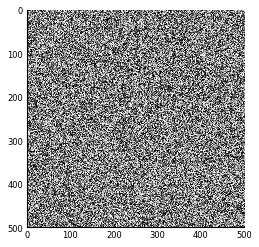

In [3]:
import numpy as np
random_image = np.random.rand(500, 500)
plt.imshow(random_image);

<!-- caption text="Image displayed by matplotlib's `imshow`" -->

This `imshow` function displays a numpy array as an image. The converse is also true: an image
can be considered as a numpy array. For this example we use the scikit-image
library, a collection of image processing tools built on top of NumPy and SciPy.

Here is a PNG image from the scikit-image repository. It is a black and white
(sometimes called "grayscale") picture of some ancient Roman coins from
Pompeii, obtained from the Brooklyn Museum [^coins-source]:

![Coins image from the Brooklyn Museum](https://raw.githubusercontent.com/scikit-image/scikit-image/v0.10.1/skimage/data/coins.png)

Here is the coin image loaded with scikit-image:

Type: <class 'numpy.ndarray'> Shape: (303, 384) Data type: uint8


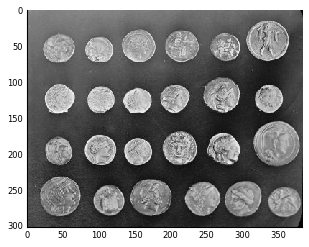

In [6]:
from skimage import io
url_coins = ('https://raw.githubusercontent.com/scikit-image/scikit-image/'
             'v0.10.1/skimage/data/coins.png')
coins = io.imread(url_coins)
print("Type:", type(coins), "Shape:", coins.shape, "Data type:", coins.dtype)
plt.imshow(coins);

<!-- caption text="Array corresponding to coins image, displayed with matplotlib" -->

A grayscale image can be represented as a *2-dimensional array*, with each array
element containing the grayscale intensity at that position. So, **an image is
just a numpy array**.

Color images are a *3-dimensional* array, where the first two dimensions
represent the spatial positions of the image, while the final dimension represents
color channels, typically the three primary additive colors of red, green, and blue.
To show what we can do with these dimensions, let's play with this photo of astronaut Eileen Collins:

Type: <class 'numpy.ndarray'> Shape: (512, 512, 3) Data type: uint8


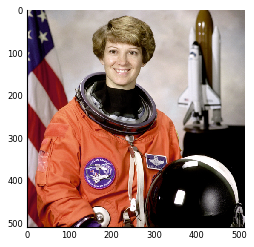

In [7]:
url_astronaut = ('https://raw.githubusercontent.com/scikit-image/scikit-image/'
                 'master/skimage/data/astronaut.png')
astro = io.imread(url_astronaut)
print("Type:", type(astro), "Shape:", astro.shape, "Data type:", astro.dtype)
plt.imshow(astro);

<!-- caption text="Image of astronaut Eileen Collins" -->

This image is *just numpy arrays*. Adding a green square to the image is easy
once you realize this, using simple numpy slicing:

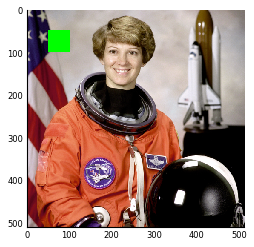

In [8]:
astro_sq = np.copy(astro)
astro_sq[50:100, 50:100] = [0, 255, 0]  # red, green, blue
plt.imshow(astro_sq);

<!-- caption text="Modified image of Eileen Collins" -->

You can also use a boolean *mask*, an array of `True` or `False` values.
We saw these in Chapter 2 as a way to select rows of a table. In this case, we
can use an array of the same shape as the image to select pixels:

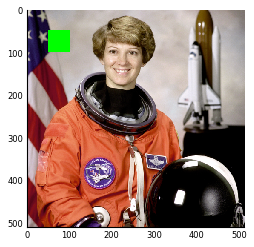

In [9]:
astro_sq = np.copy(astro)
sq_mask = np.zeros(astro.shape[:2], bool)
sq_mask[50:100, 50:100] = True
astro_sq[sq_mask] = [0, 255, 0]
plt.imshow(astro_sq);

<!-- caption text="Another modified image of Eileen Collins" -->

<!-- exercise begin -->

**Exercise:** We just saw how to select a square and paint it green. Can you
extend that to other shapes and colors? Create a function to draw a blue grid
onto a color image, and apply it to the `astronaut` image of Eileen Collins
(above). Your function should take
two parameters: the input image, and the grid spacing.
Use the following template to help you get started.

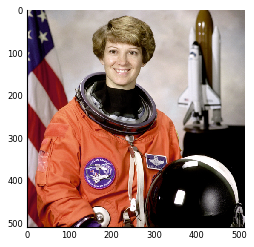

In [11]:
def overlay_grid(image, spacing=128):
    """Return an image with a grid overlay, using the provided spacing.

    Parameters
    ----------
    image : array, shape (M, N, 3)
        The input image.
    spacing : int
        The spacing between the grid lines.

    Returns
    -------
    image_gridded : array, shape (M, N, 3)
        The original image with a blue grid superimposed.
    """
    image_gridded = image.copy()
    pass  # replace this line with your code...
    return image_gridded

# plt.imshow(overlay_grid(astro, 128)); # uncomment this line to test your function

<!-- solution begin -->

**Solution:** We can use numpy slicing to select the rows of the grid, set them
to blue, and then select the columns, and set them to blue as well:

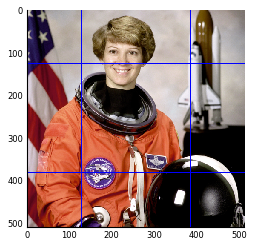

In [12]:
def overlay_grid(image, spacing=128):
    """Return an image with a grid overlay, using the provided spacing.

    Parameters
    ----------
    image : array, shape (M, N, 3)
        The input image.
    spacing : int
        The spacing between the grid lines.

    Returns
    -------
    image_gridded : array, shape (M, N, 3)
        The original image with a blue grid superimposed.
    """
    image_gridded = image.copy()
    image_gridded[spacing:-1:spacing, :] = [0, 0, 255]
    image_gridded[:, spacing:-1:spacing] = [0, 0, 255]
    return image_gridded

plt.imshow(overlay_grid(astro, 128));

<!-- caption text="Astronaut image overlaid with a grid" -->

Note that we used `-1` to mean the last value of the axis, as is standard in
Python indexing. You can omit this value, but the meaning is slightly
different. Without it (i.e. `spacing::spacing`), you go all the way to the end
of the array, including the final row/column. When you use it as the stop
index, you prevent the final row from being selected. In the case of a grid
overlay, this is probably the desired behavior.

<!-- solution end -->

<!-- exercise end -->

## Filters in signal processing

Filtering is one of the most fundamental and common operations in image
processing. You can filter an image to remove noise, to enhance features, or to
detect edges between objects in the image.

To understand filters, it's easiest to start with a 1D signal, instead of an image. For
example, you might measure the light arriving at your end of a fiber-optic cable.
If you *sample* the signal every millisecond (ms) for 100ms, you end up with an
array of length 100. Suppose that after 30ms the light signal is turned on, and
30ms later, it is switched off. You end up with a signal like this:

In [ ]:
sig = np.zeros(100, np.float) #
sig[30:60] = 1  # signal = 1 during the period 30-60ms because light is observed
fig, ax = plt.subplots()
ax.plot(sig);
ax.set_ylim(-0.1, 1.1);

<!-- caption text="Step signal" -->

To find *when* the light is turned on, you can *delay* it by 1ms, then
*subtract* the original from the delayed signal. This way, when the signal is
unchanged from one millisecond to the next, the subtraction will give zero,
but when the signal *increases*, you will get a positive signal.

When the signal *decreases*, we will get a negative signal. If we are
only interested in pinpointing the time when the light was turned on, we can
*clip* the difference signal, so that any negative values are converted to 0.

In [ ]:
sigdelta = sig[1:]  # sigdelta[0] equals sig[1], and so on
sigdiff = sigdelta - sig[:-1]
sigon = np.clip(sigdiff, 0, np.inf)
fig, ax = plt.subplots()
ax.plot(sigon)
ax.set_ylim(-0.1, 1.1)
print('Signal on at:', 1 + np.flatnonzero(sigon)[0], 'ms')

<!-- caption text="Shifted difference of a step signal" -->

(Here we have used NumPy's `flatnonzero` function to get the first index where
the `sigon` array is not equal to 0.)

It turns out that this can be accomplished by an signal processing operation
called *convolution*. At every point of the signal, we compute the dot-product
between the values surrounding that point and a *kernel* or *filter*, which is a
predetermined vector of values. Depending on the kernel, then, the convolution
shows a different feature of the signal.

Now, think of what happens when the kernel is (1, 0, -1), the difference
filter, for a signal `s`. At any position `i`, the convolution result is
`1*s[i+1] + 0*s[i] - 1*s[i-1]`, that is, `s[i+1] - s[i-1]`.
Thus, when the values adjacent to `s[i]` are identical, the convolution gives 0, but when
`s[i+1] > s[i-1]` (the signal is increasing), it gives a positive value, and,
conversely, when `s[i+1] < s[i-1]`, it gives a negative value. You can think
of this as an estimate of the derivative of the input function.

In general, the formula for convolution is:
$s'(t) = \sum_{j=t-\tau}^{t}{s(j)f(t-j)}$
where $s$ is the signal, $s'$ is the filtered signal, $f$ is the filter, and
$\tau$ is the length of the filter.

In scipy, you can use the `scipy.ndimage.convolve` to work on this.

In [ ]:
diff = np.array([1, 0, -1])
from scipy import ndimage as ndi
dsig = ndi.convolve(sig, diff)
plt.plot(dsig);

<!-- caption text="Result of convolving a difference filter with a step signal" -->

Signals are usually *noisy* though, not perfect as above:

In [ ]:
np.random.seed(0)
sig = sig + np.random.normal(0, 0.3, size=sig.shape)
plt.plot(sig);

<!-- caption text="Step signal corrupted by noise" -->

The plain difference filter can amplify that noise:

In [ ]:
plt.plot(ndi.convolve(sig, diff));

<!-- caption text="Difference filtering of a noisy signal" -->

In such cases, you can add smoothing to the filter. The most common form of
smoothing is *Gaussian* smoothing, which takes the weighted average of
neighboring points in the signal using the
[Gaussian function](https://en.wikipedia.org/wiki/Gaussian_function). We can
write a function to make a Gaussian smoothing kernel as follows:

In [ ]:
def gaussian_kernel(size, sigma):
    """Make a 1D Gaussian kernel of the specified size and standard deviation.

    The size should be an odd number and at least ~6 times greater than sigma
    to ensure sufficient coverage.
    """
    positions = np.arange(size) - size // 2
    kernel_raw = np.exp(-positions**2 / (2 * sigma**2))
    kernel_normalized = kernel_raw / np.sum(kernel_raw)
    return kernel_normalized

A really nice feature feature of convolution is that it's *associative*,
meaning if you want to find the derivative of the smoothed signal, you can
equivalently convolve the signal with the smoothed difference filter! This can
save a lot of computation time, because you can smooth just the filter, which
is usually much smaller than the data.

In [ ]:
smooth_diff = ndi.convolve(gaussian_kernel(25, 3), diff)
plt.plot(smooth_diff);

<!-- caption text="Smoothed difference filter" -->

This smoothed difference filter looks for an edge in the central position,
but also for that difference to continue. This continuation happens in the case
of a true
edge, but not in "spurious" edges caused by noise. Check out the result:

In [ ]:
sdsig = ndi.convolve(sig, smooth_diff)
plt.plot(sdsig);

<!-- caption text="Smoothed difference filter applied to a noisy signal" -->

Although it still looks wobbly, the *signal-to-noise ratio* (SNR),
is much greater in this version than when using the simple difference filter.

> **A note about filtering** {.callout}
>
> This operation is called filtering because, in physical electrical circuits,
> many of these operations are implemented by hardware that allows certain
> kinds of current through, while blocking others; these hardware components
> are called filters. For example, a common filter that removes high-frequency
> voltage fluctuations from a current is called a *low-pass filter*.

## Filtering images (2D filters)

Now that you've seen filtering in 1D, we hope you'll find it straightforward to
extend these concepts to 2D signals, such as images. Here's a 2D difference
filter for finding the edges in the coins image:

In [ ]:
coins = coins.astype(float) / 255  # prevents overflow errors
diff2d = np.array([[0, 1, 0], [1, 0, -1], [0, -1, 0]])
coins_edges = ndi.convolve(coins, diff2d)
io.imshow(coins_edges);

<!-- caption text="Result of a 2D difference filter applied to the coins image" -->

The principle is the same as the 1D filter: at every point in the image, place the
filter, compute the dot-product of the filter's values with the image values, and
place the result at the same location in the output image. And, as with the 1D
difference filter, when the filter is placed on a location with little variation, the
dot-product cancels out to zero, whereas, placed on a location where the
image brightness is changing, the values multiplied by 1 will be different from
those multiplied by -1, and the filtered output will be a positive or negative
value (depending on whether the image is brighter towards the bottom-right
or top-left at that point).

Just as with the 1D filter, you can get more sophisticated and smooth out
noise right within the filter. The *Sobel* filter is designed to do just that.
It comes in horizontal and vertical varieties, to find edges with that
orientation in the data.
Let's start with the horizontal filter first.
To find a horizontal edge in a picture, you might try the following filter:

In [ ]:
# column vector (vertical) to find horizontal edges
hdiff = np.array([[1], [0], [-1]])

However, as we saw with 1D filters, this will result in a noisy estimate of the
edges in the image. But rather than using Gaussian smoothing, which can cause
blurry edges, the Sobel filter uses the property that edges in images tend to
be continuous: a picture of the ocean, for example, will contain a horizontal
edge along an entire line, not just at specific points of the image. So the
Sobel filter smooths the vertical filter horizontally: it looks for a strong
edge at the central position that is corroborated by the adjacent positions:

In [ ]:
hsobel = np.array([[ 1,  2,  1],
                   [ 0,  0,  0],
                   [-1, -2, -1]])

The vertical Sobel filter is simply the transpose of the horizontal:

In [ ]:
vsobel = hsobel.T

We can then find the horizontal and vertical edges in the coins image:

In [ ]:
# Some custom x-axis labelling to make our plots easier to read
def reduce_xaxis_labels(ax, factor):
    """Show only every ith label to prevent crowding on x-axis
        e.g. factor = 2 would plot every second x-axis label,
        starting at the first.

    Parameters
    ----------
    ax : matplotlib plot axis to be adjusted
    factor : int, factor to reduce the number of x-axis labels by
    """
    plt.setp(ax.xaxis.get_ticklabels(), visible=False)
    for label in ax.xaxis.get_ticklabels()[::factor]:
        label.set_visible(True)


coins_h = ndi.convolve(coins, hsobel)
coins_v = ndi.convolve(coins, vsobel)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(coins_h, cmap=plt.cm.RdBu)
axes[1].imshow(coins_v, cmap=plt.cm.RdBu)
for ax in axes:
    reduce_xaxis_labels(ax, 2)


<!-- caption text="Directional Sobel filters applied to the coins image" -->

And finally, just like the Pythagorean theorem, you can argue that the edge
magnitude in *any* direction is equal to the square root of the sum of squares
of the horizontal and vertical components:

In [ ]:
coins_sobel = np.sqrt(coins_h**2 + coins_v**2)
plt.imshow(coins_sobel, cmap='viridis');

<!-- caption text="Sobel gradient magnitude of the coins image" -->

## Generic filters: arbitrary functions of neighborhood values

In addition to dot-products, implemented by `ndi.convolve`, SciPy lets you
define a filter that is an *arbitrary function* of the points in a neighborhood,
implemented in `ndi.generic_filter`. This can let you express arbitrarily
complex filters.

For example, suppose an image represents median house values in a county,
with a 100m x 100m resolution. The local council decides to tax house sales as
&#36;10,000 plus 5% of the 90th percentile of house prices in a 1km radius. (So,
selling a house in an expensive neighborhood costs more.) With
`generic_filter`, we can produce the map of the tax rate everywhere in the map:

In [ ]:
from skimage import morphology
def tax(prices):
    return 10000 + 0.05 * np.percentile(prices, 90)
house_price_map = (0.5 + np.random.rand(100, 100)) * 1e6
footprint = morphology.disk(radius=10)
tax_rate_map = ndi.generic_filter(house_price_map, tax, footprint=footprint)
plt.imshow(tax_rate_map)
plt.colorbar();

<!-- caption text="Generic filter applied to a random image" -->

<!-- exercise begin -->

**Exercise:** Conway's Game of Life.

Suggested by Nicolas Rougier.

Conway's [Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) is a
seemingly simple construct in which "cells" on a regular square grid live or die
according to the cells in their immediate surroundings. At every timestep, we
determine the state of position (i, j) according to its previous state and that
of its 8 neighbors (above, below, left, right, and diagonals):

- a live cell with only one live neighbor or none dies.
- a live cell with two or three live neighbors lives on for another generation.
- a live cell with four or more live neighbors dies, as if from overpopulation.
- a dead cell with exactly three live neighbors becomes alive, as if by
  reproduction.

Although the rules sound like a contrived math problem, they in fact give rise
to incredible patterns, starting with gliders (small patterns of live cells
that slowly move in each generation) and glider guns (stationary patterns that
sprout off gliders), all the way up to prime number generator machines (see,
for example,
[this page](http://www.njohnston.ca/2009/08/generating-sequences-of-primes-in-conways-game-of-life/)),
and even
[simulating Game of Life itself](https://www.youtube.com/watch?v=xP5-iIeKXE8)!

Can you implement the Game of Life using `ndi.generic_filter`?

<!-- solution begin -->

**Solution:**

Nicolas Rougier (@rougier) provides a NumPy-only solution on his 100 NumPy
Exercises page (Exercise #79):

In [ ]:
def next_generation(Z):
    N = (Z[0:-2,0:-2] + Z[0:-2,1:-1] + Z[0:-2,2:] +
         Z[1:-1,0:-2]                + Z[1:-1,2:] +
         Z[2:  ,0:-2] + Z[2:  ,1:-1] + Z[2:  ,2:])

    # Apply rules
    birth = (N==3) & (Z[1:-1,1:-1]==0)
    survive = ((N==2) | (N==3)) & (Z[1:-1,1:-1]==1)
    Z[...] = 0
    Z[1:-1,1:-1][birth | survive] = 1
    return Z

Then we can start a board with:

In [ ]:
random_board = np.random.randint(0, 2, size=(50, 50))
n_generations = 100
for generation in range(n_generations):
    random_board = next_generation(random_board)

Using generic filter makes it even easier:

In [ ]:
def nextgen_filter(values):
    center = values[len(values) // 2]
    neighbors_count = np.sum(values) - center
    if neighbors_count == 3 or (center and neighbors_count == 2):
        return 1.
    else:
        return 0.

def next_generation(board):
    return ndi.generic_filter(board, nextgen_filter,
                              size=3, mode='constant')

The nice thing is that some formulations of the Game of Life use what's known
as a *toroidal board*, which means that the left and right ends "wrap around"
and connect to each other, as well as the top and bottom ends. With
`generic_filter`, it's trivial to modify our solution to incorporate this:

In [ ]:
def next_generation_toroidal(board):
    return ndi.generic_filter(board, nextgen_filter,
                              size=3, mode='wrap')

We can now simulate this toroidal board for a few generations:

In [ ]:
random_board = np.random.randint(0, 2, size=(50, 50))
n_generations = 100
for generation in range(n_generations):
    random_board = next_generation_toroidal(random_board)

<!-- solution end -->

<!-- exercise end -->

<!-- exercise begin -->

**Exercise:** Sobel gradient magnitude.

Above, we saw how we can combine the output of two different filters, the
horizontal Sobel filter, and the vertical one. Can you write a function that
does this in a single pass using `ndi.generic_filter`?

<!-- solution begin -->

In [ ]:
hsobel = np.array([[ 1,  2,  1],
                   [ 0,  0,  0],
                   [-1, -2, -1]])

vsobel = hsobel.T

hsobel_r = np.ravel(hsobel)
vsobel_r = np.ravel(vsobel)

def sobel_magnitude_filter(values):
    h_edge = values @ hsobel_r
    v_edge = values @ vsobel_r
    return np.hypot(h_edge, v_edge)

Now we can try it out on the coins image:

In [ ]:
sobel_mag = ndi.generic_filter(coins, sobel_magnitude_filter, size=3)
plt.imshow(sobel_mag, cmap='viridis');

<!-- caption text="Sobel magnitude implemented by `generic_filter`" -->

<!-- solution end -->

<!-- exercise end -->

## グラフとNetworkXライブラリ

Graphs are a natural representation for an astonishing variety of data. Pages
on the world wide web, for example, can comprise nodes, while links between
those pages can be, well, links. Or, in biology, so-called *transcription
networks* have nodes represent genes and edges connect genes that have a direct
influence on each other's expression.

> **Note: graphs and networks {.callout}**
>
> In this context, the term "graph" is synonymous with "network", not with
> "plot". Mathematicians and computer scientists invented slightly different
> words to discuss these: graph = network, vertex = node, edge = link = arc. As
> most people do, we will be using these terms interchangeably.
>
> You might be slightly more familiar with the network terminology: a network
> consists of *nodes* and *links* between the nodes. Equivalently, a graph
> consists of *vertices* and *edges* between the vertices. In NetworkX, you
> have `Graph` objects consisting of `nodes` and `edges` between the nodes, and
> this is probably the most common usage.

To introduce you to graphs, we will reproduce some results from the paper
["Structural properties of the *Caenorhabditis elegans* neuronal network"](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1001066), by Lav Varshney *et al*, 2011.

In our example, we will represent neurons in the nematode worm's nervous system as
nodes, and place an edge between two nodes when a neuron makes a synapse with
another. (*Synapses* are the chemical connections through which neurons
communicate.) The worm is an awesome example of neural connectivity analysis
because every worm (of this species) has the same number of neurons (302), and the
connections between them are all known. This has resulted in the fantastic Openworm
project [^openworm], which we encourage you to read more about.

You can download the neuronal dataset in Excel format from the WormAtlas
database at [http://www.wormatlas.org/neuronalwiring.html#Connectivitydata](http://www.wormatlas.org/neuronalwiring.html#Connectivitydata).
The `pandas` library allows one to read an Excel table over the web, so we will
use it here to read in the data, then feed that into NetworkX.

In [ ]:
import pandas as pd
connectome_url = 'http://www.wormatlas.org/images/NeuronConnect.xls'
conn = pd.read_excel(connectome_url)

`conn` now contains a pandas DataFrame, with rows of the form:

[Neuron1, Neuron2, connection type, strength]

We are only going to examine the connectome of chemical synapses, so we filter
out other synapse types as follows:

In [ ]:
conn_edges = [(n1, n2, {'weight': s})
              for n1, n2, t, s in conn.itertuples(index=False, name=None)
              if t.startswith('S')]

(Look at the WormAtlas page for a description of the different connection types.)

We use `weight` in a dictionary above because it is a special keyword for
edge properties in NetworkX. We then build the graph using NetworkX's
`DiGraph` class:

In [ ]:
import networkx as nx
wormbrain = nx.DiGraph()
wormbrain.add_edges_from(conn_edges)

We can now examine some of the properties of this network. One of the
first things researchers ask about directed networks is which nodes are
the most critical to information flow within it. Nodes with high
*betweenness centrality* are those that belong to the shortest path between
many different pairs of nodes. Think of a rail network: certain stations will
connect to many lines, so that you will be forced to change lines there
for many different trips. They are the ones with high betweenness
centrality.

With NetworkX, we can find similarly important neurons with ease. In the
NetworkX API documentation [^nxdoc], under "centrality", the docstring
for `betweenness_centrality` [^bwcdoc] specifies a function that takes a
graph as input and returns a dictionary mapping node IDs to betweenness
centrality values (floating point values).

In [ ]:
centrality = nx.betweenness_centrality(wormbrain)

Now we can find the neurons with highest centrality using the Python built-in
function `sorted`:

In [ ]:
central = sorted(centrality, key=centrality.get, reverse=True)
print(central[:5])

This returns the neurons AVAR, AVAL, PVCR, PVT, and PVCL, which have been
implicated in how the worm responds to prodding: the AVA neurons link
the worm's front touch receptors (among others) to neurons responsible
for backward motion, while the PVC neurons link the rear touch receptors to
forward motion.

Varshney *et al* study the properties of a *strongly connected component*
of 237 neurons, out of a total of 279. In graphs, a
*connected component* is a set of nodes that are reachable by some path
through all the links. The connectome is a *directed* graph, meaning the
edges *point* from one node to the other, rather than merely connecting
them. In this case, a strongly connected component is one where all nodes
are reachable from each other by traversing links *in the correct direction*.
So A $\rightarrow$ B $\rightarrow$ C is not strongly connected, because there is no way to get to
A from B or C. However, A $\rightarrow$ B $\rightarrow$ C $\rightarrow$ A *is* strongly connected.

In a neuronal circuit, you can think of the strongly connected component
as the "brain" of the circuit, where the processing happens, while nodes
upstream of it are inputs, and nodes downstream are outputs.

> **Cycles in neuronal networks {.callout}**
>
> The idea of cyclical neuronal circuits dates back to the 1950s. Here's a
> lovely paragraph about this idea from an article in *Nautilus*,
> "The Man Who Tried to Redeem the World With Logic", by Amanda Gefter:
>
> > If one were to see a lightning bolt flash on the sky, the eyes would send a signal to the brain, shuffling it through a chain of neurons. Starting with any given neuron in the chain, you could retrace the signal's steps and figure out just how long ago the lightning struck. Unless, that is, the chain is a loop. In that case, the information encoding the lightning bolt just spins in circles, endlessly. It bears no connection to the time at which the lightning actually occurred. It becomes, as McCulloch put it, "an idea wrenched out of time." In other words, a memory.

NetworkX makes straightforward work out of getting the largest strongly
connected component from our `wormbrain` network:

In [ ]:
sccs = nx.strongly_connected_component_subgraphs(wormbrain)
giantscc = max(sccs, key=len)
print(f'The largest strongly connected component has '
      f'{giantscc.number_of_nodes()} nodes, out of '
      f'{wormbrain.number_of_nodes()} total.')

As noted in the paper, the size of this component is *smaller* than
expected by chance, demonstrating that the network is segregated into
input, central, and output layers.

Now we reproduce figure 6B from the paper, the survival function of the
in-degree distribution. First, compute the relevant quantities:

In [ ]:
in_degrees = list(dict(wormbrain.in_degree()).values())
in_deg_distrib = np.bincount(in_degrees)
avg_in_degree = np.mean(in_degrees)
cumfreq = np.cumsum(in_deg_distrib) / np.sum(in_deg_distrib)
survival = 1 - cumfreq

Then, plot using Matplotlib:

In [ ]:
fig, ax = plt.subplots()
ax.loglog(np.arange(1, len(survival) + 1), survival)
ax.set_xlabel('in-degree distribution')
ax.set_ylabel('fraction of neurons with higher in-degree distribution')
ax.scatter(avg_in_degree, 0.0022, marker='v')
ax.text(avg_in_degree - 0.5, 0.003, 'mean=%.2f' % avg_in_degree)
ax.set_ylim(0.002, 1.0);

<!-- caption text="The degree distribution of the worm connectome" -->

There you have it: a reproduction of a scientific analysis, using SciPy. We are
missing the line fit.... But that's what exercises are for.

<!-- exercise begin -->

This exercise is a bit of a preview for chapter 7 (optimization):
use `scipy.optimize.curve_fit` to fit the tail of the
in-degree survival function to a power-law,
$f(d) \sim d^{-\gamma}, d > d_0$,
for $d_0 = 10$ (the red line in Figure 6B of the paper), and modify the plot
to include that line.

<!-- solution begin -->

**Solution:** Let's look at the start of the docstring for `curve_fit`:

```
Use non-linear least squares to fit a function, f, to data.

Assumes ``ydata = f(xdata, *params) + eps``

Parameters
----------
f : callable
    The model function, f(x, ...).  It must take the independent
    variable as the first argument and the parameters to fit as
    separate remaining arguments.
xdata : An M-length sequence or an (k,M)-shaped array
    for functions with k predictors.
    The independent variable where the data is measured.
ydata : M-length sequence
    The dependent data --- nominally f(xdata, ...)
```


It looks like we just need to provide a function that takes in a data point,
and some parameters, and returns the predicted value. In our case, we want the
cumulative remaining frequency, $f(d)$ to be proportional to $d^{-\gamma}$.
That means we need $f(d) = \alpha d^{-gamma}$:

In [ ]:
def fraction_higher(degree, alpha, gamma):
    return alpha * degree ** (-gamma)

Then, we need our x and y data to fit, *for $d > 10$*:

In [ ]:
x = 1 + np.arange(len(survival))
valid = x > 10
x = x[valid]
y = survival[valid]

We can now use `curve_fit` to obtain fit parameters:

In [ ]:
from scipy.optimize import curve_fit

alpha_fit, gamma_fit = curve_fit(fraction_higher, x, y)[0]

Let's plot the results to see how we did:

In [ ]:
y_fit = fraction_higher(x, alpha_fit, gamma_fit)

fig, ax = plt.subplots()
ax.loglog(np.arange(1, len(survival) + 1), survival)
ax.set_xlabel('in-degree distribution')
ax.set_ylabel('fraction of neurons with higher in-degree distribution')
ax.scatter(avg_in_degree, 0.0022, marker='v')
ax.text(avg_in_degree - 0.5, 0.003, 'mean=%.2f' % avg_in_degree)
ax.set_ylim(0.002, 1.0)
ax.loglog(x, y_fit, c='red');

<!-- caption text="Power law fit of the worm brain degree distribution" -->

Voilà! A full Figure 6B, fit and all!

<!-- solution end -->

<!-- exercise end -->

You now should have a fundamental understanding of graphs as a scientific
abstraction, and how to easily manipulate and analyse them using Python and
NetworkX. Now, we move on to a particular kind of graph used in image
processing and computer vision.

## 領域隣接グラフ（Region adjacency graphs）

A Region Adjacency Graph (RAG) is a representation of an image that is useful
for *segmentation*: the division of images into meaningful regions (or
*segments*). If you've seen Terminator 2, you've seen segmentation:

![Terminator vision](../images/terminator-vision.png)

Segmentation is one of those problems that humans do trivially, all the time,
without thinking, whereas computers have a hard time of it. To
understand this difficulty, look at this image:

![Face (Eileen Collins)](http://i.imgur.com/ky5qwIS.png)

While you see a face, a computer only sees a bunch of numbers:

```
    58688888888888899998898988888666532121
    66888886888998999999899998888888865421
    66665566566689999999999998888888888653
    66668899998655688999899988888668665554
    66888899998888888889988888665666666543
    66888888886868868889998888666688888865
    66666443334556688889988866666666668866
    66884235221446588889988665644644444666
    86864486233664666889886655464321242345
    86666658333685588888866655659381366324
    88866686688666866888886658588422485434
    88888888888688688888866566686666565444
    88888888868666888888866556688666686555
    88888988888888888888886656888688886666
    88889999989998888888886666888888868886
    88889998888888888888886566888888888866
    88888998888888688888666566868868888888
    68888999888888888868886656888888888866
    68888999998888888688888655688888888866
    68888999886686668886888656566888888886
    88888888886668888888888656558888888886
    68888886665668888889888555555688888886
    86868868658668868688886555555588886866
    66688866468866855566655445555656888866
    66688654888886868666555554556666666865
    88688658688888888886666655556686688665
    68888886666888888988888866666656686665
    66888888845686888999888886666556866655
    66688888862456668866666654431268686655
    68688898886689696666655655313668688655
    68888898888668998998998885356888986655
    68688889888866899999999866666668986655
    68888888888866666888866666666688866655
    56888888888686889986868655566688886555
    36668888888868888868688666686688866655
    26686888888888888888888666688688865654
    28688888888888888888668666668686666555
    28666688888888888868668668688886665548
```


Our visual system is so optimized to spot faces that you might see the
face even in this blob of numbers! But we hope our point is made. Also,
you might want to look for the "Faces In Things" Tumblr, which demonstrates
the face-finding optimization of our visual systems far more humorously.

At any rate, the challenge is to make sense of those numbers, and where the
boundaries lie that divide the different parts of the image. A popular
approach is to find small regions (called superpixels) that
you're *sure* belong in the same segment, and then merge those according
to some more sophisticated rule.

As a simple example, suppose you want to segment out the tiger in this
picture, from the Berkeley Segmentation Dataset (BSDS):

![BSDS-108073 tiger](http://www.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/108073.jpg)

A clustering algorithm, simple linear iterative clustering (SLIC) [^slic], can give
us a decent starting point. It is available in the scikit-image library.

In [13]:
url = ('http://www.eecs.berkeley.edu/Research/Projects/CS/vision/'
       'bsds/BSDS300/html/images/plain/normal/color/108073.jpg')
tiger = io.imread(url)
from skimage import segmentation
seg = segmentation.slic(tiger, n_segments=30, compactness=40.0,
                        enforce_connectivity=True, sigma=3)

Scikit-image also has a function to *display* segmentations, which we use to
visualize the result of SLIC:

/Users/miyamoto/.pyenv/versions/miniconda3-4.1.11/envs/py35/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/miyamoto/.pyenv/versions/miniconda3-4.1.11/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


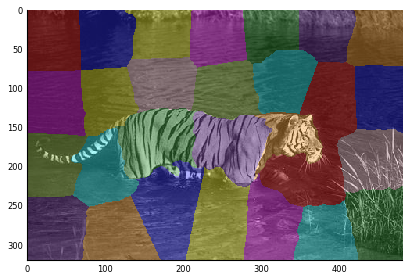

In [14]:
from skimage import color
io.imshow(color.label2rgb(seg, tiger));

<!-- caption text="SLIC segmentation of the tiger image" -->


This shows that the body of the tiger has been split in three parts, with the
rest of the image in the remaining segments.

領域隣接グラフ（A region adjacency graph (RAG) ）は全てのノードが領域（セグメント）のいずれか1つを表す。エッジが2つの接するノードを結合するグラフ。

show_ragでまずは表示してみる。

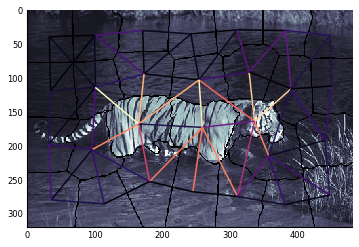

In [15]:
from skimage.future import graph

g = graph.rag_mean_color(tiger, seg)
graph.show_rag(seg, g, tiger);

<!-- caption text="Region adjacency graph overlaid on the tiger image" -->

Here, you can see the nodes corresponding to each segment, and the edges
between adjacent segments. These are colored with the YlGnBu (yellow-green-blue)
colormap from matplotlib, according to the difference in color between the
two nodes.

The figure also shows the magic of thinking of segmentations as graphs: you can
see that edges between nodes within the tiger and those outside of it are brighter
(higher-valued) than edges within the same object. Thus, if we can cut the
graph along those edges, we will get our segmentation. We have chosen an easy
example for color-based segmentation, but the same principles hold true for
graphs with more complicated pairwise relationships.



## skimageのsegmentation.slicの中身が知り合い場合


[skimage](https://github.com/scikit-image/scikit-image/blob/master/skimage/segmentation/slic_superpixels.py#L11)

[SLIC Superpixels Compared
to State-of-the-Art Superpixel Methods](http://www.kev-smith.com/papers/SMITH_TPAMI12.pdf)

[わかりやすいサイト](http://www.sanko-shoko.net/note.php?id=mpfg)

アルゴリズム
- 等間隔のsuperpixel領域を決める
- 各点の所属するsuperpixelを決める
- 各superpixelのパラメータを更新


## エレガントなndimage: 画像領域からグラフを構築する方法

All the pieces are in place: you know about numpy arrays, image filtering,
generic filters, graphs, and region adjacency graphs. Let's build one to pluck
the tiger out of that picture!

The obvious approach is to use two nested for-loops to iterate over every pixel
of the image, look at the neighboring pixels, and checking for different labels:

In [20]:
import networkx as nx
from scipy import ndimage as ndi

def build_rag(labels, image):
    g = nx.Graph()
    nrows, ncols = labels.shape
    for row in range(nrows):
        for col in range(ncols):
            current_label = labels[row, col]
            if not current_label in g:
                g.add_node(current_label)
                g.node[current_label]['total color'] = np.zeros(3, dtype=np.float)
                g.node[current_label]['pixel count'] = 0
            if row < nrows - 1 and labels[row + 1, col] != current_label:
                g.add_edge(current_label, labels[row + 1, col])
            if col < ncols - 1 and labels[row, col + 1] != current_label:
                g.add_edge(current_label, labels[row, col + 1])
            g.node[current_label]['total color'] += image[row, col]
            g.node[current_label]['pixel count'] += 1
    return g

Whew! This works, but if you want to segment a 3D image, you'll have to write a
different version:

In [21]:
import networkx as nx
def build_rag_3d(labels, image):
    g = nx.Graph()
    nplns, nrows, ncols = labels.shape
    for pln in range(nplns):
        for row in range(nrows):
            for col in range(ncols):
                current_label = labels[pln, row, col]
                if not current_label in g:
                    g.add_node(current_label)
                    g.node[current_label]['total color'] = np.zeros(3, dtype=np.float)
                    g.node[current_label]['pixel count'] = 0
                if pln < nplns - 1 and labels[pln + 1, row, col] != current_label:
                    g.add_edge(current_label, labels[pln + 1, row, col])
                if row < nrows - 1 and labels[pln, row + 1, col] != current_label:
                    g.add_edge(current_label, labels[pln, row + 1, col])
                if col < ncols - 1 and labels[pln, row, col + 1] != current_label:
                    g.add_edge(current_label, labels[pln, row, col + 1])
                g.node[current_label]['total color'] += image[pln, row, col]
                g.node[current_label]['pixel count'] += 1
    return g

Both of these are pretty ugly and unwieldy, too. And difficult to extend:
if we want to count diagonally neighboring pixels as adjacent (that is,
[row, col] is "adjacent to" [row + 1, col + 1]), the code becomes even
messier. And if we want to analyze 3D video, we need yet another
dimension, and another level of nesting. It's a mess!

Enter Vighnesh's insight: SciPy's `generic_filter` function already does
this iteration for us! We used it above to compute an arbitrarily
complicated function on the neighborhood of every element of a numpy
array. Only now we don't want a filtered image out of the function: we
want a graph. It turns out that `generic_filter` lets you pass additional
arguments to the filter function, and we can use that to build the graph:

In [26]:
import networkx as nx
import numpy as np
from scipy import ndimage as nd

def add_edge_filter(values, graph):
    center = values[len(values) // 2]
    for neighbor in values:
        if neighbor != center and not graph.has_edge(center, neighbor):
            graph.add_edge(center, neighbor)
    # float return value is unused but needed by `generic_filter`
    return 0.0

#隣接領域グラフ（rag）を作る
def build_rag(labels, image):
    g = nx.Graph()
    footprint = ndi.generate_binary_structure(labels.ndim, connectivity=1)
    _ = ndi.generic_filter(labels, add_edge_filter, footprint=footprint,
                           mode='nearest', extra_arguments=(g,))
    for n in g:
        g.node[n]['total color'] = np.zeros(3, np.double)
        g.node[n]['pixel count'] = 0
    for index in np.ndindex(labels.shape):
        n = labels[index]
        g.node[n]['total color'] += image[index]
        g.node[n]['pixel count'] += 1
    return g

Here are a few reasons this is a brilliant piece of code:

- `ndi.generic_filter` iterates over array elements *with their neighbors*.
  (Use `numpy.ndindex` to simply iterate over array indices.)
- We return "0.0" from the filter function because `generic_filter` requires
  the filter function to return a float. However, we ignore the filter
  output (which is zero everywhere), and use it only for its "side effect" of adding edges to the graph.
- The loops are not nested several levels deep. This makes the code more
  compact, easier to take in in one go.
- The code works identically for 1D, 2D, 3D, or even 8D images!
- If we want to add support for diagonal connectivity, we just need to
  change the `connectivity` parameter to `ndi.generate_binary_structure`

## まとめる: 平均の色を用いた領域分割

ここまでのを全部使ってトラを切り出す。

In [23]:
g = build_rag(seg, tiger)
for n in g:
    node = g.node[n]
    node['mean'] = node['total color'] / node['pixel count']
for u, v in g.edges():
    d = g.node[u]['mean'] - g.node[v]['mean']
    g[u][v]['weight'] = np.linalg.norm(d)

各エッジには各セグメントの平均の色の差の情報が格納。この色差情報を用いてグラフのエッジを閾値でふるいわける。

In [24]:
def threshold_graph(g, t):
    to_remove = [(u, v) for (u, v, d) in g.edges(data=True)
                 if d['weight'] > t]
    g.remove_edges_from(to_remove)
threshold_graph(g, 80)

最後に「２章（the numpy index-with-an-array trick）」で学んだNumpyの配列でインデックス付けする技を使う。

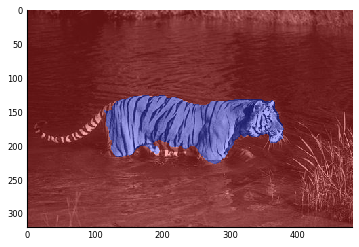

In [25]:
map_array = np.zeros(np.max(seg) + 1, int)
for i, segment in enumerate(nx.connected_components(g)):
    for initial in segment:
        map_array[int(initial)] = i
segmented = map_array[seg]
plt.imshow(color.label2rgb(segmented, tiger));

<!-- caption text="A crude, but complete, segmentation of the tiger image" -->

Oops! Looks like the cat lost its tail!

Still, we think that's a nice demonstration of the capabilities of RAGs...
And the beauty with which SciPy and NetworkX make it feasible.
Many of these functions are available in the scikit-image library. If you
are interested in image analysis, look it up!

[^alvyraysmith]: A Pixel Is Not A Little Square. Alvy Ray Smith, 1995, Technical
                 Memo. http://alvyray.com/Memos/CG/Microsoft/6_pixel.pdf

[^coins-source]: http://www.brooklynmuseum.org/opencollection/archives/image/15641/image

[^openworm]: http://www.openworm.org

[^file-url]: https://github.com/scikit-image/scikit-image/tree/master/skimage/io/util.py

[^nxdoc]: http://networkx.github.io/documentation/latest/reference/index.html

[^bwcdoc]: http://networkx.github.io/documentation/latest/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html

[^bsdstiger]: http://www.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/dataset/images/color/108073.html

[^slic]: http://ivrg.epfl.ch/research/superpixels

<!-- -->

In [38]:
url = ('http://eedog.blog.so-net.ne.jp/_images/blog/_949/eedog/E78AACE38080E6ADA9E38191E381AAE38184E38080E79785E6B0974.jpg')
tiger = io.imread(url)
from skimage import segmentation
seg = segmentation.slic(tiger, n_segments=40, compactness=40.0,
                        enforce_connectivity=True, sigma=3)

/Users/miyamoto/.pyenv/versions/miniconda3-4.1.11/envs/py35/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/miyamoto/.pyenv/versions/miniconda3-4.1.11/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


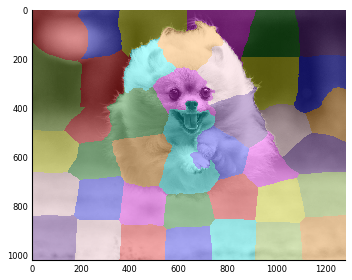

In [39]:
from skimage import color
io.imshow(color.label2rgb(seg, tiger));

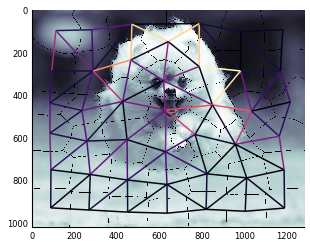

In [40]:
from skimage.future import graph

g = graph.rag_mean_color(tiger, seg)
graph.show_rag(seg, g, tiger);

In [41]:
g = build_rag(seg, tiger)
for n in g:
    node = g.node[n]
    node['mean'] = node['total color'] / node['pixel count']
for u, v in g.edges():
    d = g.node[u]['mean'] - g.node[v]['mean']
    g[u][v]['weight'] = np.linalg.norm(d)

In [42]:
def threshold_graph(g, t):
    to_remove = [(u, v) for (u, v, d) in g.edges(data=True)
                 if d['weight'] > t]
    g.remove_edges_from(to_remove)
threshold_graph(g, 70)

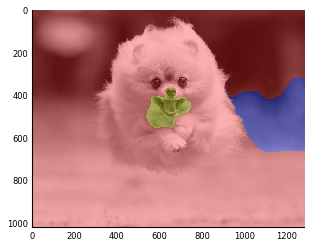

In [43]:
map_array = np.zeros(np.max(seg) + 1, int)
for i, segment in enumerate(nx.connected_components(g)):
    for initial in segment:
        map_array[int(initial)] = i
segmented = map_array[seg]
plt.imshow(color.label2rgb(segmented, tiger));

/Users/miyamoto/.pyenv/versions/miniconda3-4.1.11/envs/py35/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/miyamoto/.pyenv/versions/miniconda3-4.1.11/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


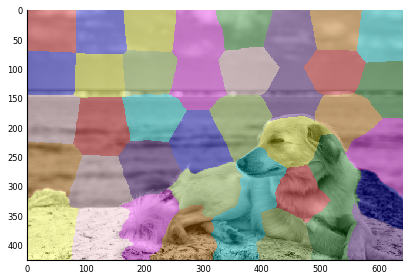

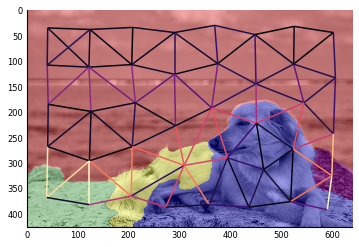

In [60]:
def run_seg(url, n_segments, compactness):
    tiger = io.imread(url)
    from skimage import segmentation
    seg = segmentation.slic(tiger, n_segments=n_segments, compactness=compactness,
                            enforce_connectivity=True, sigma=3)

    g = build_rag(seg, tiger)
    for n in g:
        node = g.node[n]
        node['mean'] = node['total color'] / node['pixel count']
    for u, v in g.edges():
        d = g.node[u]['mean'] - g.node[v]['mean']
        g[u][v]['weight'] = np.linalg.norm(d)

    g = build_rag(seg, tiger)
    for n in g:
        node = g.node[n]
        node['mean'] = node['total color'] / node['pixel count']
    for u, v in g.edges():
        d = g.node[u]['mean'] - g.node[v]['mean']
        g[u][v]['weight'] = np.linalg.norm(d)

    def threshold_graph(g, t):
        to_remove = [(u, v) for (u, v, d) in g.edges(data=True)
                     if d['weight'] > t]
        g.remove_edges_from(to_remove)
    threshold_graph(g, 70)

    map_array = np.zeros(np.max(seg) + 1, int)
    for i, segment in enumerate(nx.connected_components(g)):
        for initial in segment:
            map_array[int(initial)] = i
    segmented = map_array[seg]
    plt.imshow(color.label2rgb(segmented, tiger));
    
def run_slic(url, n_segments, compactness):
        tiger = io.imread(url)
        from skimage import segmentation
        seg = segmentation.slic(tiger, n_segments=n_segments, compactness=compactness,
                                enforce_connectivity=True, sigma=3)
        from skimage import color
        io.imshow(color.label2rgb(seg, tiger));
        
        from skimage.future import graph
        g = graph.rag_mean_color(tiger, seg)
        graph.show_rag(seg, g, tiger);
    
    
url = ('https://www.pakutaso.com/shared/img/thumb/011kumakichi0327_TP_V1.jpg')
n_segments = 40
compactness = 40.0
run_slic(url, n_segments, compactness)
run_seg(url, n_segments, compactness)

/Users/miyamoto/.pyenv/versions/miniconda3-4.1.11/envs/py35/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/miyamoto/.pyenv/versions/miniconda3-4.1.11/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


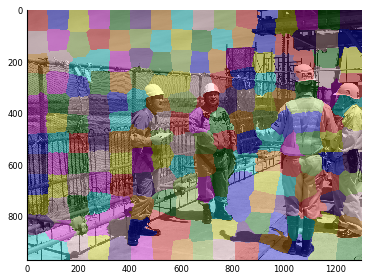

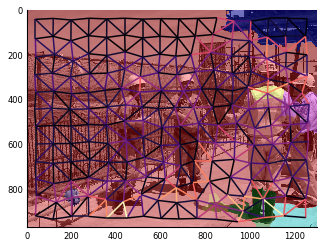

In [65]:
url = ('https://www.rodo.co.jp/wp/wp-content/uploads/2017/06/201706ishikawa-2.jpg')
n_segments = 200
compactness = 60.0
run_slic(url, n_segments, compactness)
run_seg(url, n_segments, compactness)

/Users/miyamoto/.pyenv/versions/miniconda3-4.1.11/envs/py35/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/miyamoto/.pyenv/versions/miniconda3-4.1.11/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


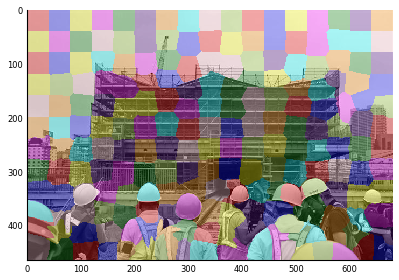

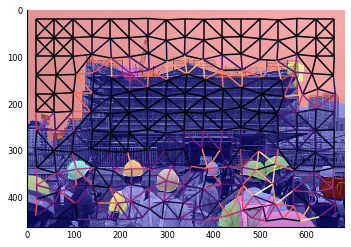

In [66]:
url = ('https://www.sankei.com/photo/images/news/180829/jnl1808290001-f1.jpg')
n_segments = 200
compactness = 60.0
run_slic(url, n_segments, compactness)
run_seg(url, n_segments, compactness)

/Users/miyamoto/.pyenv/versions/miniconda3-4.1.11/envs/py35/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/miyamoto/.pyenv/versions/miniconda3-4.1.11/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


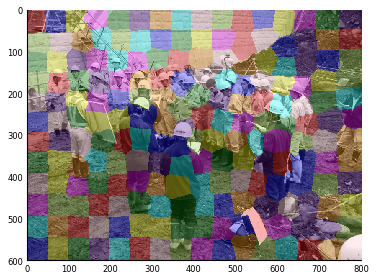

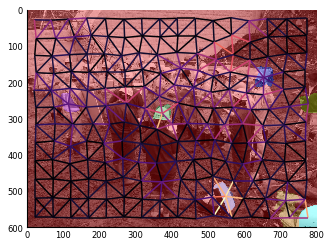

In [67]:
url = ('http://www.rinya.maff.go.jp/tohoku/syo/tugaru/jouhouhatushin/img/dscn0493.jpg')
n_segments = 200
compactness = 60.0
run_slic(url, n_segments, compactness)
run_seg(url, n_segments, compactness)